$\newcommand{\underbr}[2]{\underbrace{#1}_{\scriptscriptstyle{#2}}}$
# Multi-Layer Perceptron for binary classification in Python 
## **Author: Davy Simeu**

### Objective
We want to implement a two-layer Multi-Layer Perceptron (MLP) with 1 hidden layer in Python (from scratch), for a classification problem.

The output of the network is simply the output of several cascaded functions:
- Linear transformations. The weights of a linear transformation is denoted by $W$
- Additive biases denoted by $b$
- Non-linearities/Activation functions such as ``ReLU``, ``sigmoid``

For this, we will implement the:
- forward propagation
- computation of the cost/loss
- backward propagation (to calculate the gradients)
- update of the parameters

Furthermore, we define the following sizes:
- $n^{[0]}$: number of input neurons
- $n^{[1]}$: number of neurons in hidden layer
- $n^{[2]}$: number of neurons in output layer
- $m$: number of training data points

### Cost function
The **cost** is the average of the **loss** over the training data. Since we are dealing with a binary classification problem, we will use the binary cross-entropy.

$\mathcal{L} = - \big( y \log(\hat{y}) + (1-y) \log(1-\hat{y}) \big)$

where 
- $y$ are the ground-truth labels of the data (the true class)
- $\hat{y}$ the estimated labels (outputs of the network, the predicted class).

### Forward propagation
Following the flow of a data point in the network we have:

- $\large \underbr{Z^{[1]}}{(m,n^{[1]})} = \underbr{X}{(m,n^{[0]})} \underbr{W^{[1]}}{(n^{[0]},n^{[1]})}  + \underbr{b^{[1]}}{(n^{[1]},)} $
- $\large \underbr{A^{[1]}}{(m,n^{[1]})} = f(Z^{[1]})$
- $\large \underbr{Z^{[2]}}{(m,n^{[2]})} = \underbr{A^{[1]}}{(m,n^{[1]})} \underbr{W^{[2]}}{(n^{[1]},n^{[2]})}  + \underbr{b^{[2]}}{(n^{[2]},)}$
- $\large \underbr{A^{[2]}}{(m,n^{[2]})} = \sigma(Z^{[2]})$

where 
- $f$ is a ```ReLU``` function
- $\sigma$ is a ``sigmoid`` function

### Backward propagation
Using the chain rule we obtain:

- $\large \underbr{dZ^{[2]}}{(m,n^{[2]})} = \underbr{A^{[2]}}{(m,n^{[2]})} - \underbr{Y}{(m,n^{[2]})}$
- $\large \underbr{dW^{[2]}}{(n^{[1]},n^{[2]})} = \frac{1}{m} {\underbr{A^{[1]}}{(m,n^{[1]})}}^{T} \underbr{dZ^{[2]}}{(m,n^{[2]})} $
- $\large \underbr{db^{[2]}}{(n^{[2]},)} = \frac{1}{m} \sum_{i=1}^{m} \underbr{dZ^{[2]}}{(m,n^{[2]})}$
- $\large \underbr{dA^{[1]}}{(m,n^{[1]})} = \underbr{dZ^{[2]}}{(m,n^{[2]})} {\underbr{W^{[2]}}{(n^{[1]},n^{[2]})}}^{T} $
- $\large \underbr{dZ^{[1]}}{(m,n^{[1]})} = \underbr{dA^{[1]}}{(m,n^{[1]})} \: \odot \: f' (\underbr{Z^{[1]}}{(m,n^{[1]})})$
- $\large \underbr{dW^{[1]}}{(n^{[0]},n^{[1]})} = \frac{1}{m} {\underbr{X}{(m,n^{[0]})}}^{T} \underbr{dZ^{[1]}}{(m,n^{[1]})} $
- $\large \underbr{db^{[1]}}{(n^{[1]},)} = \frac{1}{m} \sum_{i=1}^{m} \underbr{dZ^{[1]}}{(m,n^{[1]})}$

### Parameters update
- We will implement a **first version** in which the parameters are updated using a **batch gradient descent**:
    - $W(t) = W(t-1) - \alpha dW(t)$

- Besides, we will also implement a **second version** in which the parameters are updated using the **momentum method**:
    - $V_{dW}(t) = \beta V_{dW}(t-1) + (1-\beta) dW(t)$
    - $W(t) = W(t-1) - \alpha V_{dW}(t)$

**NOTE: The $\odot$ operator refers to the point-wise multiplication operation. The matrix multiplication operation can be carried out in Python using ```np.dot()```.**

# Load packages

In [1]:
%matplotlib inline
import numpy as np
from sklearn import datasets
from sklearn import model_selection
import matplotlib.pyplot as plt

# Define a set of functions

In [2]:
def F_standardize(X):
    """
    Standardize X, i.e. subtract mean (over data) and divide by standard-deviation (over data)
    
    Parameters
    ----------
    X: np.array of size (m, n_0)
        matrix containing the observation data
    
    Returns
    -------
    X: np.array of size (m, n_0)
        standardize version of X
    """
    X -= np.mean(X, axis=0, keepdims=True) 
    X /= (np.std(X, axis=0, keepdims=True) + 1e-16)
    
    return X

In [3]:
def sigmoid(x):
    """Compute the value of the sigmoid activation function"""
    return 1 / (1 + np.exp(-x))

def relu(x):
    """Compute the value of the Rectified Linear Unit activation function"""
    return x * (x > 0)

def dRelu(x):
    """Compute the derivative of the Rectified Linear Unit activation function"""
    x[x<=0] = 0
    x[x>0] = 1
    
    return x

def computeCost(hat_y, y):
    """Compute the cost (sum of the losses)
    
    Parameters
    ----------
    hat_y: (m, 1)
        predicted value by the MLP
    y: (m, 1)
        ground-truth class to predict
    """
    m = y.shape[0]
    loss =  -(y * np.log(hat_y) + (1-y) * np.log(1-hat_y))
    cost = np.sum(loss)/m
    
    return cost

def computeAccuracy(hat_y, y):
    """Compute the accuracy
    
    Parameters
    ----------
    hat_y: (m, 1)
        predicted value by the MLP
    y: (m, 1)
        ground-truth class to predict
    """
    m = y.shape[0]    
    class_y = np.copy(hat_y)
    class_y[class_y>=0.5]=1 # fix a threshold to 0.5
    class_y[class_y<0.5]=0
    
    return np.sum(class_y==y)/m

# Load dataset and pre-process it

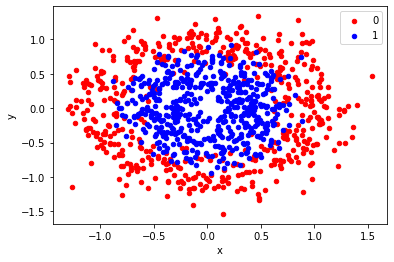

In [4]:
X, y = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)

from pandas import DataFrame
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [5]:
print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))
print(set(y))

# X is (m, n_0)
# y is (m,)

# --- Standardize data
X = F_standardize(X)

# --- Split between training set and test set
# --- (m, n_0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

# --- Convert to proper shape: (m,) -> (m, 1)
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

# --- Convert to oneHotEncoding: (nbExamples, 1) -> (nbExamples, nbClass)
n_0 = X_train.shape[1]
n_2 = 1

print("X_train.shape: {}".format(X_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("y_train.shape: {}".format(y_train.shape))
print("y_test.shape: {}".format(y_test.shape))
print("y_train.shape: {}".format(y_train.shape))
print("y_test.shape: {}".format(y_test.shape))
print("n_0=n_in: {} n_2=n_out: {}".format(n_0, n_2))

X.shape: (1000, 2)
y.shape: (1000,)
{0, 1}
X_train.shape: (800, 2)
X_test.shape: (200, 2)
y_train.shape: (800, 1)
y_test.shape: (200, 1)
y_train.shape: (800, 1)
y_test.shape: (200, 1)
n_0=n_in: 2 n_2=n_out: 1


# Define the ``MultiLayerPerceptron`` class

In [6]:
class MultiLayerPerceptron:
    """
    A class used to represent a Multi-Layer Perceptron with 1 hidden layer

    Attributes
    ----------
    W1, b1, W2, b2:
        weights and biases to be learnt
    Z1, A1, Z2, A2:
        values of the internal neurons to be used for backpropagation
    dW1, db1, dW2, db2, dZ1, dZ2:
        partial derivatives of the loss w.r.t. parameters
        example: dW1 = dLoss/dW1
    VdW1, Vdb1, VdW2, Vdb2:
        momentum terms

    Methods
    -------
    forward: 
        Forward propagation in the MLP
    backward: 
        Backward propagation in the MLP
    gradient_descent: 
        Update MLP parameters using batch gradient descent 
    momentum: 
        Same as above but using momentum method
    
    """
    
    W1, b1, W2, b2 = [], [], [], []
    A0, Z1, A1, Z2, A2 = [], [], [], [], []
    dW1, db1, dW2, db2 = [], [], [], []   
    dZ1, dA1, dZ2 = [], [], []
    # for momentum
    VdW1, Vdb1, VdW2, Vdb2 = [], [], [], []     
    
    def __init__(self, n_0, n_1, n_2):
        self.W1 = np.random.randn(n_0, n_1) * 0.01
        self.b1 = np.zeros(shape=(1, n_1))
        self.W2 = np.random.randn(n_1, n_2) * 0.01
        self.b2 = np.zeros(shape=(1, n_2))        
        # for momentum
        self.VdW1 = np.zeros(shape=(n_0, n_1)) 
        self.Vdb1 = np.zeros(shape=(1, n_1))
        self.VdW2 = np.zeros(shape=(n_1, n_2))
        self.Vdb2 = np.zeros(shape=(1, n_2))
        return
    
    def __setattr__(self, attrName, val):
        if hasattr(self, attrName):
            self.__dict__[attrName] = val
        else:
            raise Exception("self.%s note part of the fields" % attrName)

    def forward(self, X):
        """Forward propagation in the MLP

        Parameters
        ----------
        X: numpy array of shape (m, n_1)
            observation data

        Return
        ------
        hat_y: numpy array of shape (m, 1)
            predicted value by the MLP
        """
        self.A0 = X
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = sigmoid(self.Z2)
        hat_y = self.A2
        
        return hat_y

    def backward(self, X, y):
        """Backward propagation in the MLP

        Parameters
        ----------
        X: numpy array of shape (m, n_0)
            observation data
        y: numpy array of shape (m, 1)
            ground-truth class to predict
            
        """
        m = y.shape[0]
        self.dZ2 = self.A2 - y
        self.dW2 = np.dot(self.A1.T, self.dZ2) / m
        self.db2 = np.sum(self.dZ2) / m
        self.dA1 = np.dot(self.dZ2, self.W2.T)

        self.dZ1 = self.dA1 * dRelu(self.Z1)
        self.dW1 = np.dot(X.T, self.dZ1) / m
        self.db1 = np.sum(self.dZ1) / m
    
    def gradient_descent(self, alpha):
        """Update the parameters of the network using gradient descent

        Parameters
        ----------
        alpha: float
            amount of update at each step of the gradient descent
            
        """
        self.W1 = self.W1 - alpha * self.  C
        self.b1 = self.b1 - alpha * self.db1
        self.W2 = self.W2 - alpha * self.dW2
        self.b2 = self.b2 - alpha * self.db2
    
    def momentum(self, alpha, beta):
        """Update the parameters of the network using momentum method

        Parameters
        ----------
        alpha: float
            amount of update at each step of the momentum
        beta: float
            momentum term 
        """
        self.VdW1 = beta * self.VdW1 + (1 - beta)*self.dW1
        self.W1 = self.W1 - alpha * self.VdW1

        self.Vdb1 = beta * self.Vdb1 + (1 - beta)*self.db1
        self.b1 = self.b1 - alpha * self.Vdb1

        self.VdW2 = beta * self.VdW2 + (1 - beta)*self.dW2
        self.W2 = self.W2 - alpha * self.VdW2

        self.Vdb2 = beta * self.Vdb2 + (1 - beta)*self.db2
        self.b2 = self.b2 - alpha * self.Vdb2
        
    def train(self, nb_epoch=5000, alpha=0.1, beta=0.9):
        """Train the 

        Args:
            nb_epoch (int, optional): number of epochs (number of iterations over full training set). Defaults to 5000.
            alpha (float, optional): learning rate_description_. Defaults to 0.1.
            beta (float, optional): beta parameter for momentum. Defaults to 0.9.
        """
        
        # hyper-parameters

 # 
 # 
 # 

# Run over epochs
for num_epoch in range(0, nb_epoch):
    
    # --- Forward
    hat_y_train = self.forward(X_train)
    
    # --- Store results on train
    train_cost.append(computeCost(hat_y_train, y_train))
    train_accuracy.append(computeAccuracy(hat_y_train, y_train))
    
    # --- Backward
    self.backward(X_train, y_train)
    
    # --- Update
    #self.gradient_descent(alpha)
    self.momentum(alpha, beta)

    # --- Store results on test
    hat_y_test = self.forward(X_test)
    test_cost.append(computeCost(hat_y_test, y_test))    
    test_accuracy.append(computeAccuracy(hat_y_test, y_test))
    
    if not(num_epoch % 500): 
        print("epoch: {0:d} (cost: train {1:.2f} test {2:.2f}) (accuracy: train {3:.2f} test {4:.2f})".format(num_epoch, train_cost[-1], test_cost[-1], train_accuracy[-1], test_accuracy[-1]))

# Perform training using batch gradient descent

In [7]:

# Instantiate the class MLP with providing 
# the size of the various layers (n_0=n_input, n_1=n_hidden, n_2=n_output)
n_1 = 10 # number of hidden neurons
myMLP = MultiLayerPerceptron(n_0, n_1, n_2)
train_cost, train_accuracy, test_cost, test_accuracy = [], [], [], []

epoch: 0 (cost: train 0.69 test 0.69) (accuracy: train 0.50 test 0.48)
epoch: 500 (cost: train 0.68 test 0.68) (accuracy: train 0.68 test 0.67)
epoch: 1000 (cost: train 0.40 test 0.40) (accuracy: train 0.88 test 0.87)
epoch: 1500 (cost: train 0.28 test 0.29) (accuracy: train 0.88 test 0.89)
epoch: 2000 (cost: train 0.25 test 0.27) (accuracy: train 0.90 test 0.89)
epoch: 2500 (cost: train 0.24 test 0.26) (accuracy: train 0.90 test 0.90)
epoch: 3000 (cost: train 0.24 test 0.26) (accuracy: train 0.90 test 0.90)
epoch: 3500 (cost: train 0.24 test 0.26) (accuracy: train 0.90 test 0.90)
epoch: 4000 (cost: train 0.24 test 0.26) (accuracy: train 0.90 test 0.90)
epoch: 4500 (cost: train 0.24 test 0.26) (accuracy: train 0.90 test 0.90)


## Display train/test loss and accuracy

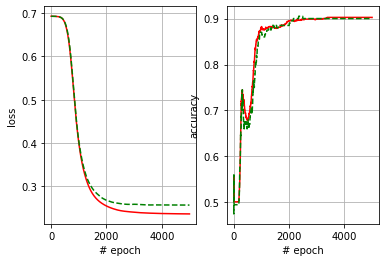

In [8]:
plt.subplot(1,2,1)
plt.plot(train_cost, 'r')
plt.plot(test_cost, 'g--')
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r')
plt.plot(test_accuracy, 'g--')
plt.xlabel('# epoch')
plt.ylabel('accuracy')
plt.grid(True)